In [ ]:
#NON DEMENTED:
    #correct: 58
    #images: 64
    #percentage: 0.90625

#MODERATE DEMENTED:
    #correct: 975
    #images: 1500
    #percentage: 0.65

#MILD DEMENTED:
    #correct: 195
    #images: 450
    #percentage: 0.43333333333333335

#VERY MILD DEMENTED:
    #correct: 1216
    #images: 1500
    #percentage: 0.8106666666666666

In [1]:
#IMPORT LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:

#IMPORT / VIEWING / PREPROCESSING DATASET

In [4]:

#DATA AUGMENTATION

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [6]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Colab Notebooks/archive_y/AugmentedAlzheimerDataset',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 1600 images belonging to 4 classes.


In [7]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Colab Notebooks/archive_y/AugmentedAlzheimerDataset',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 400 images belonging to 4 classes.


100%|██████████| 5/5 [04:30<00:00, 54.08s/it]


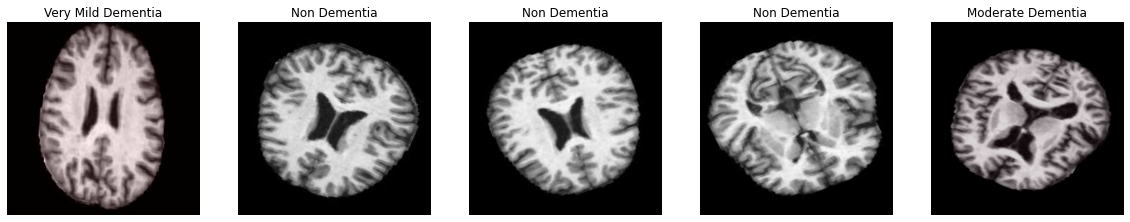

In [8]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Dementia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [9]:
#MODEL BUILDING

In [10]:
base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

51877672/51877672 [==============================] - 4s 0us/step


In [11]:

# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [12]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [13]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              166987776 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [14]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [15]:
# Defining Callbacks

filepath = '/content/drive/MyDrive/Colab Notebooks/best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [16]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 1.6616 - auc: 0.6771 
Epoch 1: val_auc improved from -inf to 0.66539, saving model to /content/drive/MyDrive/Colab Notebooks/best_weights.hdf5
13/13 [==============================] - 697s 51s/step - loss: 1.6616 - auc: 0.6771 - val_loss: 6.5607 - val_auc: 0.6654
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 1.3049 - auc: 0.7753
Epoch 2: val_auc improved from 0.66539 to 0.73942, saving model to /content/drive/MyDrive/Colab Notebooks/best_weights.hdf5
13/13 [==============================] - 38s 3s/step - loss: 1.3049 - auc: 0.7753 - val_loss: 3.5725 - val_auc: 0.7394
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 1.1109 - auc: 0.8252
Epoch 3: val_auc did not improve from 0.73942
13/13 [==============================] - 26s 2s/step - loss: 1.1109 - auc: 0.8252 - val_loss: 4.2963 - val_auc: 0.6820
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 1.0526 - a

In [17]:
#MODEL EVALUATION

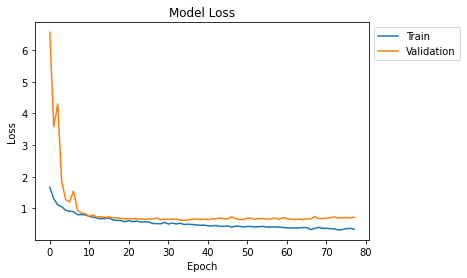

In [18]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

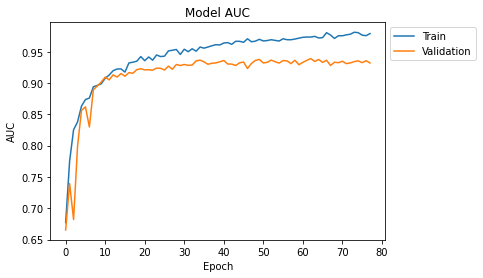

In [19]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [20]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 3514 images belonging to 4 classes.


In [21]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

28/28 [==============================] - 353s 13s/step - loss: 0.9126 - auc: 0.9033


[0.9126121997833252, 0.9033473134040833]

1/1 [==============================] - 4s 4s/step
92.0 % chances are there that the image is NonDemented


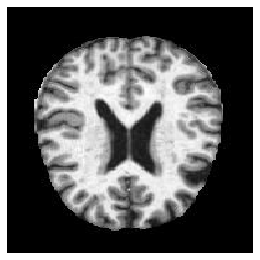

In [22]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/NonDemented/26 (63).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 77ms/step
50.2 % chances are there that the image is NonDemented


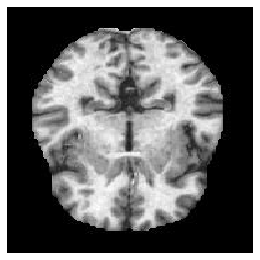

In [23]:
# Test Case 1_1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/NonDemented/nonDem279.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 46ms/step
83.72 % chances are there that the image is NonDemented


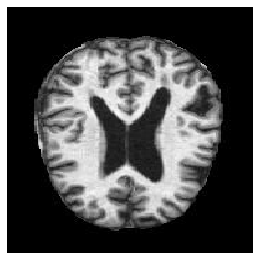

In [24]:
# Test Case 1_2: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/NonDemented/26 (89).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 44ms/step
99.94 % chances are there that the image is NonDemented


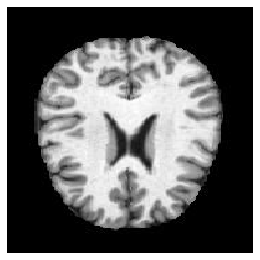

In [25]:
# Test Case 1_3: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/NonDemented/27 (13).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 52ms/step
53.94 % chances are there that the image is VeryMildDemented


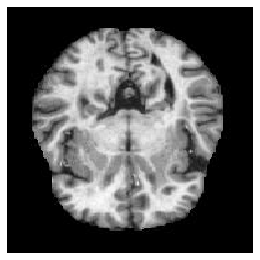

In [26]:
# Test Case 1_4: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/NonDemented/nonDem0.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 44ms/step
53.84 % chances are there that the image is VeryMildDemented


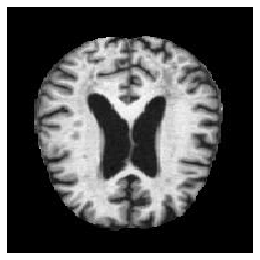

In [27]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/MildDemented/26 (25).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 68ms/step
65.42 % chances are there that the image is MildDemented


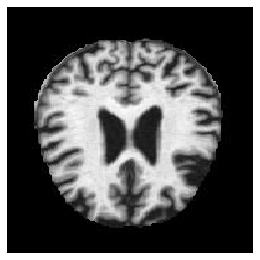

In [28]:
# Test Case 2_1: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/MildDemented/31 (6).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 92ms/step
66.88 % chances are there that the image is VeryMildDemented


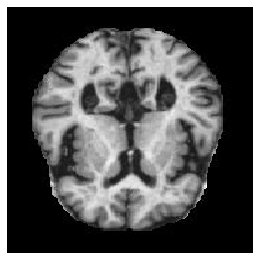

In [30]:
# Test Case 2_2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/MildDemented/mildDem162.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 46ms/step
66.05 % chances are there that the image is MildDemented


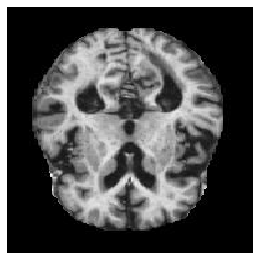

In [31]:
# Test Case 2_3: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/MildDemented/mildDem95.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 44ms/step
93.55 % chances are there that the image is MildDemented


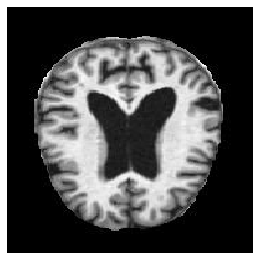

In [32]:
# Test Case 2_4: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/MildDemented/26 (21).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 45ms/step
99.22 % chances are there that the image is MildDemented


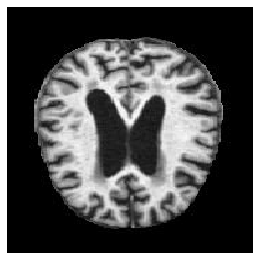

In [33]:
# Test Case 2_5: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/MildDemented/28 (11).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 118ms/step
99.69 % chances are there that the image is ModerateDemented


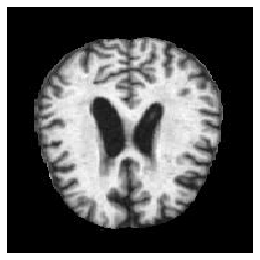

In [34]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/ModerateDemented/28.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 67ms/step
99.99 % chances are there that the image is ModerateDemented


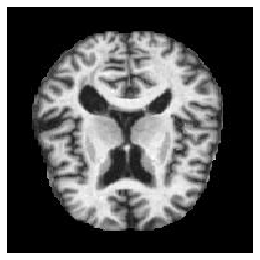

In [35]:
# Test Case 3_1: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/ModerateDemented/moderateDem29.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 69ms/step
96.68 % chances are there that the image is ModerateDemented


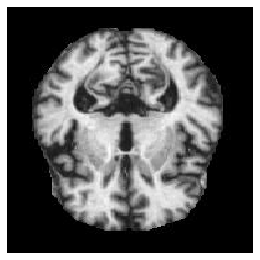

In [36]:
# Test Case 3_2: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/ModerateDemented/moderateDem7.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 108ms/step
98.82 % chances are there that the image is ModerateDemented


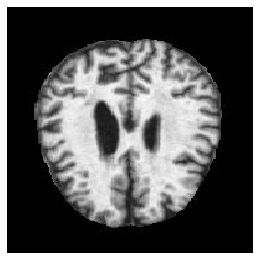

In [37]:
# Test Case 3_3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/ModerateDemented/32.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 45ms/step
99.67 % chances are there that the image is ModerateDemented


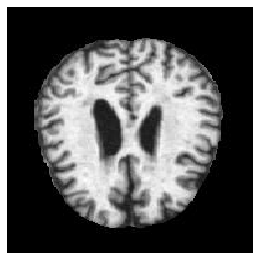

In [38]:
# Test Case 3_4: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/ModerateDemented/30.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 66ms/step
95.33 % chances are there that the image is VeryMildDemented


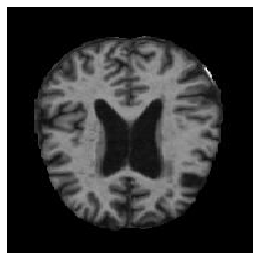

In [39]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/VeryMildDemented/26 (46).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 88ms/step
68.14 % chances are there that the image is MildDemented


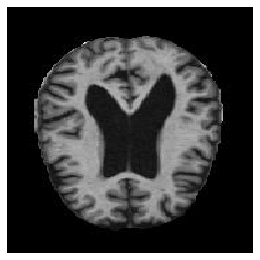

In [40]:
# Test Case 4_1: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/VeryMildDemented/26 (70).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 50ms/step
99.72 % chances are there that the image is MildDemented


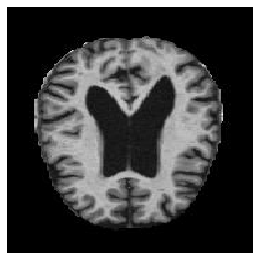

In [41]:
# Test Case 4_2: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/VeryMildDemented/27 (70).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 49ms/step
93.21 % chances are there that the image is VeryMildDemented


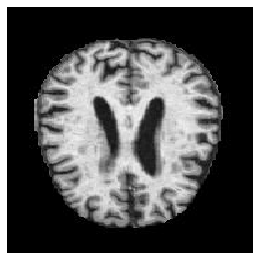

In [42]:
# Test Case 4_3: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/VeryMildDemented/29 (40).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 60ms/step
43.38 % chances are there that the image is MildDemented


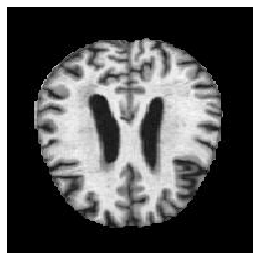

In [43]:
# Test Case 4_4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/VeryMildDemented/31 (41).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 99ms/step
99.98 % chances are there that the image is VeryMildDemented


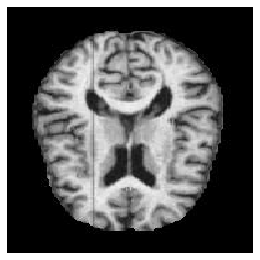

In [44]:
# Test Case 4_5: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/VeryMildDemented/verymildDem1028.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 70ms/step
99.3 % chances are there that the image is VeryMildDemented


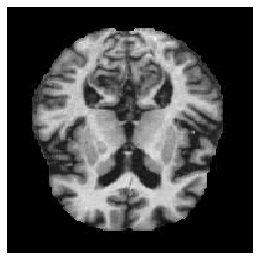

In [45]:
# Test Case 4_6: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/VeryMildDemented/verymildDem430.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 49ms/step
98.28 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 33ms/step
99.82 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 40ms/step
99.81 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 41ms/step
70.39 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 32ms/step
99.64 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 33ms/step
99.92 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 32ms/step
99.97 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 33ms/step
99.58 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 35ms/step
82.99 % chances are there that the image is Mode

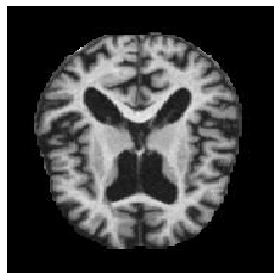

In [52]:


import cv2
import glob 

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

for img_x in glob.glob("/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/ModerateDemented/*.jpg"):
  img = cv2.imread(img_x)
  img = load_img(img_x, target_size = (224,224,3))
  #img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/VeryMildDemented/verymildDem430.jpg', target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  imshow(img)
  plt.axis('off')
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  print(probability, '% chances are there that the image is',idc[answer[0]])

In [64]:
# MODERATE 

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/ModerateDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "ModerateDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 34ms/step
correct: 58
images: 64
percentage: 0.90625


1/1 [==============================] - 0s 113ms/step
83.22 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 120ms/step
86.99 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 94ms/step
99.96 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 33ms/step
99.46 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 102ms/step
44.85 % chances are there that the image is VeryMildDemented
1/1 [==============================] - 0s 41ms/step
80.99 % chances are there that the image is NonDemented
1/1 [==============================] - 0s 34ms/step
92.39 % chances are there that the image is NonDemented
1/1 [==============================] - 0s 35ms/step
82.53 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 38ms/step
56.99 % chances are there that the image is VeryMildDemented
1/1 [=====

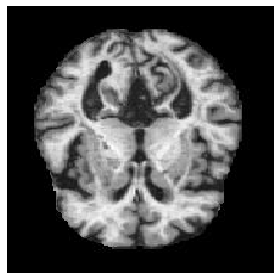

In [53]:
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

for img_x in glob.glob("/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/MildDemented/*.jpg"):
  img = cv2.imread(img_x)
  img = load_img(img_x, target_size = (224,224,3))
  #img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/VeryMildDemented/verymildDem430.jpg', target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  imshow(img)
  plt.axis('off')
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  print(probability, '% chances are there that the image is',idc[answer[0]])

In [65]:
# MILD

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/MildDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "MildDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 35ms/step
correct: 195
images: 450
percentage: 0.43333333333333335


In [66]:
# NON

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/NonDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "NonDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 33ms/step
correct: 975
images: 1500
percentage: 0.65


In [67]:
# VERY MILD

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/VeryMildDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "VeryMildDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 34ms/step
correct: 1216
images: 1500
percentage: 0.8106666666666666
